# 1 - Normalização e Pré-processamento:

Normalizem as observações para estarem dentro de um intervalo razoável.

Convertam as ações em um formato compatível com o ambiente e criem as funções de cada ação.
Identifiquem as features relevantes que podem ajudar o agente a aprender melhor.

Extraíam e processem essas features a partir dos dados brutos, se necessário, para facilitar o aprendizado do agente.

## Importação

In [1]:
import warnings

# Ignore DeprecationWarning
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# IMPORTANTE: Coloque os arquivos fornecidos pelo parceiro em uma pasta chamada "Data", na raiz do seu Google Drive
# Os arquivos .xlsx abaixo foram tratados previamente a partir do .xlsb enviados pelo ciente
# Consistem em ações filtradas no Excel para que constem apenas ações VALE3 (Vale ON) do CLIENTE 4 da corretora FUTU (Nova Futura).

spot_path  = '/content/drive/MyDrive/Data/2023_COMPRA_C4_VALE3_FUTU.xlsx'
futures_path = '/content/drive/MyDrive/Data/2023_VENDA_C4_VALE3_FUTU.xlsx'

In [4]:
# Bibliotecas de análise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Arquivo de compras - mercado "spot" (à vista)
df_spot = pd.read_excel(spot_path)
# Arquivo de vendas - mercado de "futures" (a termo)
df_futures = pd.read_excel(futures_path)

In [6]:
print(df_spot.head())
df_spot.dtypes

  Cód. Cliente Dt. Operação Tipo Operação Cód. Título Cód. Corretora  \
0    Cliente 4   2023-07-28             C       VALE3           FUTU   
1    Cliente 4   2023-07-28             C       VALE3           FUTU   
2    Cliente 4   2023-11-08             C       VALE3           FUTU   
3    Cliente 4   2023-09-21             C       VALE3           FUTU   
4    Cliente 4   2023-05-23             C       VALE3           FUTU   

   Quantidade      Preço  Valor Líquido Dt. Liquidação Tipo  
0         500  68.765780      -34382.89     2023-08-01   AV  
1        1500  68.865820     -103298.73     2023-08-01   AV  
2        2000  70.096110     -140192.22     2023-11-10   AV  
3       10000  67.815595     -678155.95     2023-09-25   AV  
4        2000  66.915825     -133831.65     2023-05-25   AV  


Cód. Cliente              object
Dt. Operação      datetime64[ns]
Tipo Operação             object
Cód. Título               object
Cód. Corretora            object
Quantidade                 int64
Preço                    float64
Valor Líquido            float64
Dt. Liquidação    datetime64[ns]
Tipo                      object
dtype: object

In [7]:
print(df_futures.head())
df_futures.dtypes

    Chave Cód. Cliente Dt. Operação Tipo Operação Cód. Título Cód. Corretora  \
0   5048A    Cliente 4   2023-02-10             V       VALE3           FUTU   
1   6431A    Cliente 4   2023-10-04             V       VALE3           FUTU   
2   6432A    Cliente 4   2023-10-04             V       VALE3           FUTU   
3  13878A    Cliente 4   2023-04-20             V       VALE3           FUTU   
4  13879A    Cliente 4   2023-04-20             V       VALE3           FUTU   

   Quantidade      Preço  Valor Líquido Vencimento Tipo        DI  
0         575  89.022087       51187.70 2023-04-25   TE  0.136535  
1          53  66.586981        3529.11 2023-11-03   TE  0.126429  
2          53  66.586981        3529.11 2023-11-03   TE  0.126429  
3         978  76.640153       74954.07 2023-06-19   TE  0.136376  
4          22  76.650909        1686.32 2023-06-19   TE  0.136376  


Chave                     object
Cód. Cliente              object
Dt. Operação      datetime64[ns]
Tipo Operação             object
Cód. Título               object
Cód. Corretora            object
Quantidade                 int64
Preço                    float64
Valor Líquido            float64
Vencimento        datetime64[ns]
Tipo                      object
DI                       float64
dtype: object

## Feature Engineering

### Limpeza

Os seguintes dados não são necesários para nossa análise e podem ser removidos completamente:

#### Planilha de Compra à vista (df_spot)

- Cód. Cliente: já foi filtrado previamente
- Dt. Operação: não importa, só a de liquidação
- Tipo Operação: todas são C
- Cód. Título: já foi filtrado previamente
- Cód. Corretora: já foi filtrado previamente
- Valor Líquido: não importa, pode ser calculado a partir da quantidade e preço
- Tipo: todos são AV

#### Planilha de Venda a termo (df_futures)

- Cód. Cliente: já foi filtrado previamente
- Dt. Operação: não importa, só a de vencimento
- Tipo Operação: todas são V
- Cód. Título: já foi filtrado previamente
- Cód. Corretora: já foi filtrado previamente
- Tipo: todos são TE
- Valor Líquido: não importa, pode ser calculado a partir da quantidade e preço

In [8]:
df_spot = df_spot.drop(columns=['Cód. Cliente', 'Tipo Operação', 'Dt. Operação', 'Cód. Título', 'Cód. Corretora', 'Tipo', 'Valor Líquido'])
df_futures = df_futures.drop(columns=['Cód. Cliente', 'Dt. Operação', 'Tipo Operação', 'Cód. Título', 'Cód. Corretora', 'Valor Líquido', 'Tipo'])

# Vamos adicionar uma chave sintética também para a planilha spot, assim podemos saber que ações a termo estão vinculadas a ações à vista
df_spot.insert(0,'Chave','')
df_spot['Chave'] = df_spot.index.astype(str)

# Renomear colunas para tornar mais fácil lembrar o nome
df_spot = df_spot.rename(columns={"Dt. Liquidação": "Liquidação"})


In [9]:
print(df_spot.head())
print(df_futures.head())

  Chave  Quantidade      Preço Liquidação
0     0         500  68.765780 2023-08-01
1     1        1500  68.865820 2023-08-01
2     2        2000  70.096110 2023-11-10
3     3       10000  67.815595 2023-09-25
4     4        2000  66.915825 2023-05-25
    Chave  Quantidade      Preço Vencimento        DI
0   5048A         575  89.022087 2023-04-25  0.136535
1   6431A          53  66.586981 2023-11-03  0.126429
2   6432A          53  66.586981 2023-11-03  0.126429
3  13878A         978  76.640153 2023-06-19  0.136376
4  13879A          22  76.650909 2023-06-19  0.136376


## Normalização e Features

Não podemos normalizar os dados existentes, pois eles devem ser exatos por um ou outro motivo:

- Se modificarmos as datas de vencimento ou de liquidação, isso tornará difícil estabelecer uma regra de que a liquidação tem que ocorrer antes do vencimento.

- Se modificarmos a taxa DI, será difícil construir a curva do valor descontado.

- Se normalizarmos a quantidade ou o preço, não conseguiremos estabelecer o valor exato de ações que deverão ser vinculadas por um valor específico e o parceiro precisa dessa informação.

As features serão, portanto:

- Chave das ações à vista e a termo
- Quandidade das ações disponíveis à vista e a termo
- Data de liquidação da ação à vista
- Data de vencimento da ação a termo
- Taxa DI da ação a termo

# 2 - Estabelecimento de Critérios e Função de Recompensa:

Estabeleçam critérios claros para definir um episódio.
Descrevam detalhadamente a função de recompensa.
Desenvolvam uma variável de classe "env" para iniciar as simulações durante o treinamento.

## Criar o Ambiente no Gym

In [10]:
!pip install pandas-market-calendars # biblioteca para pegar os dias úteis do ano para cálculo do valor descontado

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.7/191.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 20.1 MB/s eta 0:00:00


In [11]:
import gym # v0.25.2
from gym import spaces
import numpy as np
import pandas_market_calendars as mcal

class CashAndCarryArbitrageEnv(gym.Env):
    """Ambiente personalizado para Arbitragem de Cash and Carry usando a biblioteca gym"""

    def __init__(self, df_futures=pd.DataFrame(), df_spot=pd.DataFrame()):
        super(CashAndCarryArbitrageEnv, self).__init__()

        # Carregar dataframes de referência
        self.df_futures = df_futures
        self.df_spot = df_spot

        # Definir espaço de ação
        # 0: combinar,
        # 1: descombinar,
        # 2: passar para próxima ação a termo,
        # 3: passar para próxima ação à vista
        self.action_space = spaces.Discrete(4)

        # Definir espaço de observação
        self.observation_space = spaces.Dict(
            {
                "future_index": spaces.Discrete(len(self.df_futures)), # Indice da ação a termo atualmente sob análise
                "spot_index": spaces.Discrete(len(self.df_spot)), # Indice da ação a vista atualmente sob análise
                "future_quantity": spaces.Discrete(self.df_futures['Quantidade'].max() + 1), # Quantidade disponível para combinar do termo atual
                "available_spot_stocks": spaces.Box(low=0, high=np.inf, shape=(len(self.df_spot),), dtype=np.int64), # Quantidade de ações spot disponíveis para esse termo
                "selected_spot_stocks": spaces.Box(low=0, high=np.inf, shape=(len(self.df_spot),), dtype=np.int64), # Quantidade de ações spot selecionadas para esse termo
            }
        )

        # Inicializar estado do ambiente
        self.matches = {index: [] for index in range(len(self.df_futures))} # dicionario com as combinações, para output e para salvar na memória quando troca de termo
        self.state = {}

    def step(self, action):
        # Interpretar as ações possíveis
        match = action == 0
        unmatch = action == 1
        next_future = action == 2
        next_spot = action == 3

        # Salva o valor inicial da quantidade de termos disponíveis, para comparação posterior
        initial_future_quantity = self.state['future_quantity']

        spot_index = self.state['spot_index']
        future_index = self.state['future_index']
        # Atualizar o estado baseado na ação
        if match:
            # Selecionar um futuro e uma ação spot específicos e realizar a combinação
            current_future_quantity = self.state['future_quantity']
            current_spot_quantity = self.df_spot.at[spot_index, 'Quantidade']

            # Se as ações à vista disponíveis excederem as ações a termo, use só as ações remanescentes que tiver
            if current_future_quantity < current_spot_quantity:
                current_spot_quantity = self.state['future_quantity']

            self.state['future_quantity'] -= current_spot_quantity
            self.state['available_spot_stocks'][spot_index] -= current_spot_quantity
            self.state['selected_spot_stocks'][self.state['spot_index']] += current_spot_quantity
        elif unmatch:
            # Fazer o caminho contrário do 'match' acima
            current_spot_quantity = self.state['selected_spot_stocks'][self.state['spot_index']]

            # Nesse caso não é necessário verificar se vamos exceder as ações a termo
            self.state['future_quantity'] += current_spot_quantity
            self.state['available_spot_stocks'][spot_index] += current_spot_quantity
            self.state['selected_spot_stocks'][self.state['spot_index']] -= current_spot_quantity
        elif next_future:
            self.state['future_index'] += 1
            self._advance_to_next_eligible_spot()
            # self._advance_to_next_eligible_spot()
            # Verificar se todos as ações a termo já foram processadas (estado de parada provisório para testar a versão inicial)
            if self.state['future_index'] >= len(self.df_futures):
                self.done = True
            else:
                self.state['future_quantity']  = self.df_futures.at[self.state['future_index'], 'Quantidade']
                self.matches[self.state['future_index']] = [e for e in self.state['selected_spot_stocks']]
                self.state['selected_spot_stocks'] = np.zeros((len(self.df_spot),), dtype=np.int64)
            return self.state, 0, self.done, {} # retorna 0 como recompensa e vai para próximo futuro

        elif next_spot:
            self._advance_to_next_eligible_spot()
            return self.state, 0, self.done, {} # retorna 0 como recompensa e vai para próximo futuro


        # Calcular a recompensa
        # Após processar a ação, calcular pdv_future e obter spot_price
        pdv_future = self._compute_pdv_future()
        spot_price = self.df_spot.at[self.state['spot_index'], 'Preço']
        reward = self._calculate_reward(initial_future_quantity, pdv_future, spot_price)


        # Atualizar informações adicionais para retornar, se necessário
        info = {}

        return self.state, reward, self.done, info

    def reset(self):
        self.state['future_index'] = 0
        self.state['spot_index'] = 0

        self._advance_to_next_eligible_spot()

        # Seleciona o primeiro futuro
        self.state['future_quantity'] = self.df_futures.at[self.state['future_index'], 'Quantidade']
        self.state['available_spot_stocks'] = self.df_spot['Quantidade'].values
        self.state['selected_spot_stocks'] = np.zeros((len(self.df_spot),), dtype=np.int64)
        self.done = False

        return self.state

    def _calculate_reward(self, initial_future_quantity, pdv_future, spot_price):
        """
        Calcula a recompensa com base na quantidade de future_quantity usada e na diferença
        entre pdv_future e spot_price.
        """
        # Calcula a mudança em future_quantity como resultado da ação
        quantity_change = initial_future_quantity - self.state['future_quantity']

        # Calcula a diferença entre pdv_future e spot_price
        difference = abs(pdv_future - spot_price)

        # Formulação básica da recompensa: maior recompensa para maior redução de future_quantity
        # e penalidade proporcional à diferença de preço. Podemos ajustar os pesos conforme necessário.
        reward = quantity_change * 0.1 - difference * 10  # Aqui, o peso da quantidade usada é 10 vezes o da diferença de preço

        return reward


    def _compute_pdv_future(self):
        """
        Computa o valor presente do termo sob análise.
        """
        future = self.df_futures.iloc[self.state['future_index']]
        DI_rate = future['DI'] # em %

        spot = self.df_spot.iloc[self.state['spot_index']]

        # Cria uma instância do calendário BM&F
        bmf_calendar = mcal.get_calendar('BMF')

        # Gera um DataFrame dos dias úteis entre as datas de início e fim
        schedule = bmf_calendar.schedule(start_date=spot['Liquidação'], end_date=future['Vencimento'])

        # Calcula o número de dias úteis como o tamanho desse DataFrame
        days_until_expiration = len(schedule)

        # Calcula o PDV do futuro com base no número de dias úteis
        pdv_future = future['Preço'] / (1 + DI_rate) ** (days_until_expiration / 252)

        return pdv_future

    def _advance_to_next_eligible_spot(self):
        """
        Loop até encontrar uma ação à vista com data de liquidação antes da data de vencimento do futuro atual.
        """

        while self.state['future_index'] < len(self.df_futures) - 1:
            while self.state['spot_index'] < len(self.df_spot) - 1:  # Evita ultrapassar o limite do array
                # Incrementa o índice da ação à vista
                self.state['spot_index'] += 1

                # Obtém as datas de liquidação e vencimento para comparação
                expiration_date = self.df_futures.iloc[self.state['future_index']]['Vencimento']
                liquidation_date = self.df_spot.iloc[self.state['spot_index']]['Liquidação']

                # Verifica se a data de liquidação é antes da data de vencimento
                if liquidation_date < expiration_date:
                    return  # A ação à vista atual é elegível, interromper a função
            self.state['future_index'] += 1


## Registrar o Ambiente

In [12]:
from gym.envs.registration import register

register(
    id='CashAndCarryArbitrage-v0',
    entry_point='__main__:CashAndCarryArbitrageEnv',
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Instanciar o ambiente

In [13]:
env = gym.make('CashAndCarryArbitrage-v0', df_futures=df_futures, df_spot=df_spot)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [14]:
state_size = (sum(1 for key, space in env.observation_space.spaces.items() if isinstance(space, spaces.Discrete))
              + sum(np.prod(space.shape) for key, space in env.observation_space.spaces.items() if isinstance(space, spaces.Box)))

# Verificar a quantidade de ações
num_actions = env.action_space.n

print("Tamanho do vetor de estados:", state_size)
print("Número de ações:", num_actions)

Tamanho do vetor de estados: 63
Número de ações: 4


In [15]:
initial_state = env.reset() # resetar ambiente

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [16]:
# Seleciona uma ação, lembre-se:
# 0: combinar o termo atual com à vista atual
# 1: descombinar o termo atual com à vista atual
# 2: passar para próxima ação à vista
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Estado inicial:", initial_state)
    print("Ação tomada:", action)
    print("Próximo estado:", next_state)
    print("Recompensa recebida:", reward)
    print("Episódio terminou?:", done)
    print("Info:", info)
    print("Matches: ", env.matches)

Estado inicial: {'future_index': 0, 'spot_index': 21, 'future_quantity': 0, 'available_spot_stocks': array([  500,  1500,  2000, 10000,  2000,   800,   200,  2600,   200,
         100,   600,   500,   500,  3000, 10000,  1000,  5000,  5000,
         200,   300,   400,   425,  1900,   300,  5000,   500,  5000,
         400,   200,  1000]), 'selected_spot_stocks': array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 575,   0,   0,   0,   0,
         0,   0,   0,   0])}
Ação tomada: 0
Próximo estado: {'future_index': 0, 'spot_index': 21, 'future_quantity': 0, 'available_spot_stocks': array([  500,  1500,  2000, 10000,  2000,   800,   200,  2600,   200,
         100,   600,   500,   500,  3000, 10000,  1000,  5000,  5000,
         200,   300,   400,   425,  1900,   300,  5000,   500,  5000,
         400,   200,  1000]), 'selected_spot_stocks': array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

# 3 - Hiperparâmetros e Estrutura da Rede Neural:

Mapeiem a estrutura da rede neural que será treinada como agente.
Definam o número de entradas e descrevam cada uma delas.
Definam o número de camadas ocultas, suas funções de ativação e o número de saídas, além das funções de ativação associadas.

Observação: o código abaixo foi adaptado do modelo "Lunar Lander" do curso "Unsupervised Learning, Recommenders, Reinforcement Learning" do professor Andrew Ng, disponível em https://www.coursera.org/learn/unsupervised-learning-recommenders-reinforcement-learning/home/week/3

## Hiperparâmetros

In [17]:
MEMORY_SIZE = 100_000     # tamanho do buffer de memória
GAMMA = 0.995             # fator de desconto
ALPHA = 1e-3              # taxa de aprendizado
NUM_STEPS_FOR_UPDATE = 4  # realizar um processo de aprendizado a cada C passos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Função de transformação

Essa função é necessária pois a rede neural requer um vetor de estados e temos um dicionário. Vamos unificar o dicionário em um vetor toda vez que recebermos uma observação de estado, para passar para a rede.

In [18]:
import tensorflow as tf

from keras import Sequential
from keras.layers import Dense, Input
from keras.losses import MSE
from keras.optimizers import Adam

# Criação da Q-Network
q_network = Sequential([
    Input(shape=(state_size,)),  # Ajuste aqui
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

# Criação da "target Q-Network" com mesa arquitetura da Q-Network
target_q_network = Sequential([
    Input(shape=(state_size,)),  # Ajuste aqui
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
])

optimizer = Adam(learning_rate=ALPHA)

## Funções auxiliares

In [19]:
import base64
import random
from itertools import zip_longest

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from statsmodels.iolib.table import SimpleTable


SEED = 0              # seed para gerador de números aleatório
MINIBATCH_SIZE = 64   # tamnho do mini-batch
TAU = 1e-3            # update de parâmetros
E_DECAY = 0.995       # taxa de decay para política ε-greedy
E_MIN = 0.01          # menor valor para política ε-greedy


random.seed(SEED)

def transform_observation(observation):
    scalar_parts = [observation['future_index'], observation['spot_index'], observation['future_quantity']]
    array_parts = [observation['available_spot_stocks'], observation['selected_spot_stocks']]
    state = np.concatenate([np.array(scalar_parts), *array_parts])
    return state


def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = np.array([e.state for e in experiences if e is not None])
    actions = np.array([e.action for e in experiences if e is not None])
    rewards = np.array([e.reward for e in experiences if e is not None])
    next_states = np.array([e.next_state for e in experiences if e is not None])
    done_vals = np.array([e.done for e in experiences if e is not None])

    # Converter para tensores TensorFlow
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
    done_vals = tf.convert_to_tensor(done_vals, dtype=tf.float32)

    return (states, actions, rewards, next_states, done_vals)



def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)


def get_action(q_values, epsilon=0, num_actions=4):
    if random.random() > epsilon:
        return np.argmax(q_values[0])
    else:
        return random.choice(np.arange(num_actions))

def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)


def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):

    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]

    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')

    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'

    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
    plt.xlabel('Episódio', color=text_color, fontsize=30)
    plt.ylabel('Pontos Totais', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()


def display_table(initial_state, action, next_state, reward, done):

    action_labels = ["Combinar", "Descombinar", "Troca da à vista", "Troca da a termo"]

    # Não usar headers da Coluna
    column_headers = None

    with np.printoptions(formatter={'float': '{:.3f}'.format}):
        table_info = [("Initial State:", [f"{initial_state}"]),
                      ("Action:", [f"{action_labels[action]}"]),
                      ("Next State:", [f"{next_state}"]),
                      ("Reward Received:", [f"{reward:.3f}"]),
                      ("Episode Terminated:", [f"{done}"])]

    # Gerar tabela
    row_labels, data = zip_longest(*table_info)
    table = SimpleTable(data, column_headers, row_labels)

    return table

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4 - Seleção e Implementação do Algoritmo de Reinforcement Learning:

Escolham um algoritmo adequado para o problema, considerando a natureza dos estados, ações e a estrutura do ambiente.
Implementem o algoritmo escolhido, como Q-Learning, Policy Gradient, DQN, entre outros.


In [20]:
from collections import namedtuple

experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calcular a perda.

    Args:
      experiences: (tuple) tupla ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Desempacotar o minibatch de experiencias
    states, actions, rewards, next_states, done_vals = experiences

    # Computar max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Setar y = R se o episodio terminar, caso contrario y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Obter os q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Computar a perde
    loss = MSE(y_targets, q_values)

    return loss

In [22]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Atualizar os pesos da Q-network

    Args:
      experiences: (tuple) tupla ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) fator de desconto.

    """

    # calcular a perda
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # update dos gradientes
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # update dos pesos da q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # updates dos pesos da target network
    update_target_network(q_network, target_q_network)

# 5 - Treinamento e Otimização:

Inicializem os parâmetros do agente e da rede neural, se aplicável.
Realizem iterações de treinamento em episódios, onde o agente interage com o ambiente, atualizando seus parâmetros com base na recompensa recebida.
Avaliem o desempenho do agente em um conjunto de validação e ajustem os hiperparâmetros para otimizar seu desempenho.

In [28]:
import time
from collections import deque

start = time.time()

num_episodes = 100
max_num_timesteps = 1

total_point_history = []

num_p_av = 100    # numero de pontos
epsilon = 1.0     # ε-greedy policy

memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reiniciar o ambiente
    state = env.reset()
    state = transform_observation(state)  # Transforma o estado para o formato correto
    total_points = 0

    for t in range(max_num_timesteps):

        state_tensor = tf.expand_dims(tf.convert_to_tensor(state), 0)
        q_values = q_network.predict(state_tensor)  # Usa .predict() aqui
        action = get_action(q_values, epsilon, num_actions)

        next_state, reward, done, _ = env.step(action)
        next_state = transform_observation(next_state)  # Transforma o próximo estado

        memory_buffer.append(experience(state, action, reward, next_state, done))  # Armazena a experiência


        if check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer):
            experiences = get_experiences(memory_buffer)

            agent_learn(experiences, GAMMA)

        state = next_state  # Atualiza o estado
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update dos ε values
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisódio {i+1} | Média de pontos totais dos últimos {num_p_av} episódios: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Média de pontos totais dos últimos {num_p_av} episódios: {av_latest_points:.2f}")

    if av_latest_points >= 100_000_000.0:
        print(f"\n\nAmbiente resolvido em {i+1} episódios!")
        q_network.save('cash_and_carry_model.h5')
        break


q_network.save('cash_and_carry_model.h5')

tot_time = time.time() - start

print(f"\nTempo total de execução: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  comm

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


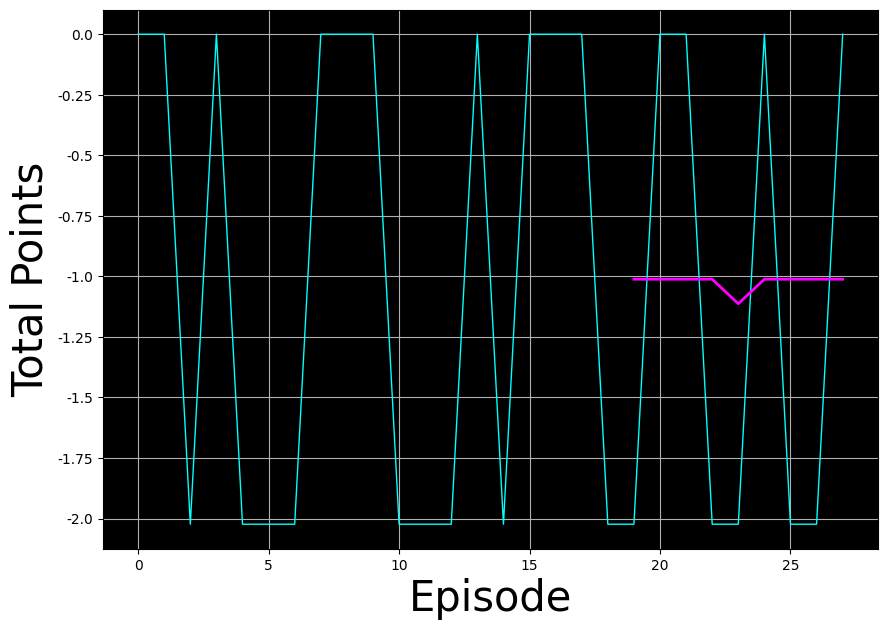

In [29]:
plot_history(total_point_history)

# Verificar Última Combinação Gerada no Treinamento


In [30]:
# Load the model
print(env.matches)

{0: [], 1: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: []}
